In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-04-04 09:47:57.041322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 09:47:57.636002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def read_data(pathC,pathE):
    df  = pd.DataFrame(columns =['x1','y1','z1','x2','y2','z2','x3','y3','z3'])
    c = []

    with open(pathC) as f:
        for line in f:
            if(line[0]=='H' or line[0]=='O'):
                cords=(line.split())
                c.append(float(cords[1]))
                c.append(float(cords[2]))
                c.append(float(cords[3]))
                
                if(len(c)==9):              
                    df.loc[len(df.index)] = c
                    c=[]

    with open(pathE) as f:
        for line in f:
            c.append(float(line.strip()))
    df.insert(9,"energy",c)

    return df


def get_dist(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2 )

def normalize_data(df):
    return df.iloc[:,0:].apply(lambda x: (x-x.mean())/(x.max() - x.min()), axis=0)

In [36]:
h2o_unrotated = read_data("./data/H2O_unrotated.xyz","./data/H2O_unrotated.ener")
h2o_test = read_data("./data/H2O_test.xyz","./data/H2O_test.ener")

In [37]:
h2o_test.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,energy
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.262051,0.244529,0.169866,0.267238,0.325589,0.294540,0.182788,0.138650,0.242392,-76.376581
std,5.611002,5.618094,5.583041,5.588828,5.597806,5.602937,5.629983,5.620287,5.619150,0.003868
min,-10.129084,-10.491242,-10.483761,-10.114744,-10.136301,-10.066855,-10.336802,-10.562103,-10.266318,-76.380751
25%,-4.300464,-4.053468,-4.435325,-4.155892,-4.114212,-4.098794,-4.374190,-4.509591,-4.164165,-76.379490
50%,-0.046320,-0.099218,0.085115,0.063512,0.022119,-0.123711,-0.156228,0.083285,-0.056152,-76.377925
75%,5.342816,5.216033,4.982472,5.037120,5.076880,5.295120,4.939527,4.842077,4.847615,-76.374541
max,10.130574,10.142946,9.807139,9.905662,10.032214,9.875521,10.425149,10.119387,10.036678,-76.355746


In [38]:
h2o_distances = pd.DataFrame(columns=['OH1','OH2','HH'])

for molecule in h2o_unrotated.iterrows():
    atoms = molecule[1]
    oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
    oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
    hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
    h2o_distances.loc[len(h2o_distances.index)] = [oh1,oh2,hh]

h2o_distances.insert(3,"energy",h2o_unrotated.energy)

In [39]:
h2o_distances_test = pd.DataFrame(columns=['OH1','OH2','HH'])

for molecule in h2o_test.iterrows():
    atoms = molecule[1]
    oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
    oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
    hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
    h2o_distances_test.loc[len(h2o_distances_test.index)] = [oh1,oh2,hh]

h2o_distances_test.insert(3,"energy",h2o_test.energy)

In [40]:
h2o_distances_test

,OH1,OH2,HH,energy
0,0.960560,0.920601,1.524000,-76.378156
1,0.927445,0.973441,1.567047,-76.378141
2,0.980598,0.944718,1.538561,-76.379999
3,0.998403,0.975693,1.559615,-76.379985
4,1.017561,0.893399,1.517483,-76.372555
...,...,...,...,...
245,0.961689,0.936657,1.523907,-76.379627
246,0.971330,0.981459,1.531466,-76.380631
247,0.965167,1.017847,1.567106,-76.378793
248,0.962003,0.872875,1.461503,-76.370272


In [43]:
inp_data = normalize_data(h2o_distances)
tst_data = normalize_data(h2o_distances_test)

In [44]:
keras.backend.clear_session()

In [45]:
model = keras.Sequential()

model.add( keras.layers.Input(shape=(3,)))
# model.add( keras.layers.Input(shape=(9,)))

model.add( keras.layers.Dense(
    32,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    16,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    8,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    1,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_bias=False
))

model.compile(optimizer=keras.optimizers.Adam(0.001),loss='mse')
model.summary()

2024-04-04 09:54:33.835147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-04 09:54:33.835485: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800 (3.12 KB)

 Trainable params: 800 (3.12 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# train, test = train_test_split(h2o_unrotated, test_size=0.2,random_state=8123)
train, val = train_test_split(inp_data, test_size=0.2,random_state=8123)
history = model.fit(train.iloc[:,0:-1],train.iloc[:,-1:],validation_data=(val.iloc[:,0:-1],val.iloc[:,-1:]),epochs=500)

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - val_loss: 0.0188
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0186
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 - val_loss: 0.0184
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0204 - val_loss: 0.0180
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184 - val_loss: 0.0178
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0175
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0191 - val_loss: 0.0170
Epoch 9/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0163
Epoch 10/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 11/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0154
Epoch 12/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

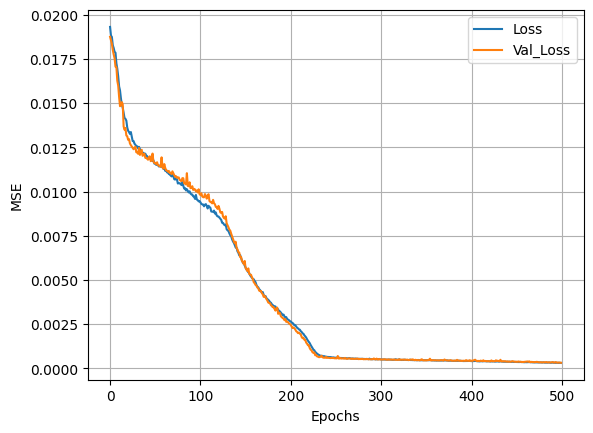

In [47]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# test_energies = h2o_test.iloc[:,-1:]
# test_cords = h2o_test.iloc[:,0:-1]

test_energies = tst_data.iloc[:,-1:]
test_cords = tst_data.iloc[:,0:-1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


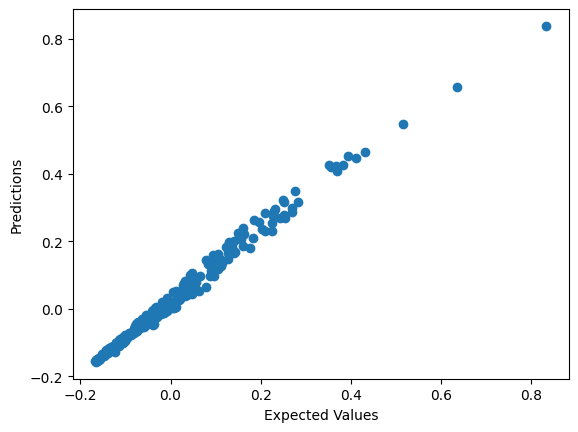

0.02906309142410959


In [50]:
predictions = model.predict(test_cords)
rmse = np.sqrt(np.mean((predictions-test_energies)**2))

plt.scatter(test_energies, predictions)
plt.xlabel('Expected Values')
plt.ylabel('Predictions')
ax = plt.gca()
# plt.plot([np.min([np.min(test_energies),np.min(predictions)]),np.max([np.max(test_energies),np.max(predictions)])], [np.min([np.min(test_energies),np.min(predictions)]),np.max([np.max(test_energies),np.max(predictions)])], 'r-')
plt.show()

print(rmse)